# Imports and Functions

In [30]:
import numpy as np
import pandas as pd

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, recall_score, precision_score, accuracy_score

from boruta import BorutaPy
import shap

import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def make_target(row):
   if (row['Bullied_on_school_property_in_past_12_months'] == 'Yes' or row['Bullied_not_on_school_property_in_past_12_months'] == 'Yes' or row['Cyber_bullied_in_past_12_months'] == 'Yes'):
      return 1
   return 0

# Data Cleaning

In [2]:
df = pd.read_csv('../data/Bullying_2018.csv', delimiter=';')
df.drop('record', axis=1, inplace=True)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese
0,Yes,Yes,,13 years old,Female,0 times,0 times,Always,2,10 or more days,Never,Always,Yes,Yes,,,
1,No,No,No,13 years old,Female,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,,,
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
3,No,No,No,16 years old,Male,0 times,2 or 3 times,Never,3 or more,0 days,Sometimes,,No,No,No,No,No
4,No,No,No,13 years old,Female,0 times,0 times,Rarely,3 or more,0 days,Most of the time,Most of the time,No,No,,,


In [3]:
# To simplify our analysis, we may just drop the missing rows
# However, there are columns with empty strings. So, we may first replace this values with nan
df.replace({' ':np.nan}, inplace=True)
df.dropna(inplace=True)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No
5,No,No,No,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No
10,No,No,No,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No
22,No,No,Yes,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No
23,No,No,No,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes


In [10]:
# Creating our target variable
df['target'] = df.apply(lambda row: make_target(row), axis=1)
df.head()

,Bullied_on_school_property_in_past_12_months,Bullied_not_on_school_property_in_past_12_months,Cyber_bullied_in_past_12_months,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,target
2,No,No,No,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,0
5,No,No,No,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No,0
10,No,No,No,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No,0
22,No,No,Yes,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No,1
23,No,No,No,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes,0


In [13]:
df.target.value_counts(normalize=True)

0    0.59363
1    0.40637
Name: target, dtype: float64

In [14]:
# Dropping the bullying features
df.drop(['Bullied_on_school_property_in_past_12_months', 'Bullied_not_on_school_property_in_past_12_months', 'Cyber_bullied_in_past_12_months'],
        axis=1,
        inplace=True)
df.head()

,Custom_Age,Sex,Physically_attacked,Physical_fighting,Felt_lonely,Close_friends,Miss_school_no_permission,Other_students_kind_and_helpful,Parents_understand_problems,Most_of_the_time_or_always_felt_lonely,Missed_classes_or_school_without_permission,Were_underweight,Were_overweight,Were_obese,target
2,14 years old,Male,0 times,0 times,Never,3 or more,0 days,Sometimes,Always,No,No,No,No,No,0
5,13 years old,Male,0 times,1 time,Never,3 or more,0 days,Most of the time,Always,No,No,No,No,No,0
10,15 years old,Male,0 times,1 time,Never,3 or more,3 to 5 days,Most of the time,Always,No,Yes,No,No,No,0
22,13 years old,Male,0 times,2 or 3 times,Most of the time,3 or more,0 days,Rarely,Always,Yes,No,No,No,No,1
23,14 years old,Male,0 times,2 or 3 times,Most of the time,2,0 days,Always,Sometimes,Yes,No,No,Yes,Yes,0


In [15]:
# Checking if there are missing values
df.isna().sum()

Custom_Age                                     0
Sex                                            0
Physically_attacked                            0
Physical_fighting                              0
Felt_lonely                                    0
Close_friends                                  0
Miss_school_no_permission                      0
Other_students_kind_and_helpful                0
Parents_understand_problems                    0
Most_of_the_time_or_always_felt_lonely         0
Missed_classes_or_school_without_permission    0
Were_underweight                               0
Were_overweight                                0
Were_obese                                     0
target                                         0
dtype: int64

# Model Development

In [18]:
# Setting the columns to ordinal or categorical
# Here, categorical columns with a sense of order (age, number of times that something hapenned) were set to ordinal

categorical_columns = [
    'Sex',
    'Felt_lonely',
    'Other_students_kind_and_helpful',
    'Parents_understand_problems',
    'Most_of_the_time_or_always_felt_lonely',
    'Missed_classes_or_school_without_permission',
    'Were_underweight',
    'Were_overweight',
    'Were_obese'
]

ordinal_columns = [
    'Custom_Age',
    'Physically_attacked',
    'Physical_fighting',
    'Close_friends',
    'Miss_school_no_permission'
]

In [19]:
# Creating the mapping order to ordinal columns

ordinal_cols_mapping = [
    ['11 years old or younger', '12 years old', '13 years old', '14 years old', '15 years old', '16 years old', '17 years old', '18 years old or older'],
    ['0 times', '1 time', '2 or 3 times', '4 or 5 times', '6 or 7 times', '8 or 9 times', '10 or 11 times', '12 or more times'],
    ['0 times', '1 time', '2 or 3 times', '4 or 5 times', '6 or 7 times', '8 or 9 times', '10 or 11 times', '12 or more times'],
    ['0', '1', '2', '3 or more'],
    ['0 days', '1 or 2 days', '3 to 5 days', '6 to 9 days', '10 or more days']
]

In [20]:
# Constructing the preprocessing pipeline

categorical_transformer = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ]
)

ordinal_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder(categories=ordinal_cols_mapping, handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('ord', ordinal_transformer, ordinal_columns)
    ]
)

In [48]:
# Defining the model pipeline

model_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight='balanced',
    n_jobs=-1,
    verbose=True
)

model_pipeline_rf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('rf', model_rf)
    ]
)

# With this set_output API we are able to track the feature names which the pipeline outputs
model_pipeline_rf.set_output(transform='pandas')

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Felt_lonely',
                                                   'Other_students_kind_and_helpful',
                                                   'Parents_understand_problems',
                                                   'Most_of_the_time_or_always_felt_lonely',
                                                   'Missed_classes_or_school_without_permission',
                                                   'Were...
                                                                                               'to '
                                                                                               '5 '
                                                                                               'days',
                                                                                               '6 '
                                                                                               'to '
                                                                                               '9 '
                                                                                               'days',
                                                                                               '10 '
                                                                                               'or '
                                                                                               'more '
                                                                                               'days']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Custom_Age',
                                                   'Physically_attacked',
                                                   'Physical_fighting',
                                                   'Close_friends',
                                                   'Miss_school_no_permission'])])),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, n_jobs=-1,
                                        verbose=True))])

In [94]:
# Train/test split

X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    random_state=123
)

In [95]:
# Fitting the model

model_pipeline_rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Felt_lonely',
                                                   'Other_students_kind_and_helpful',
                                                   'Parents_understand_problems',
                                                   'Most_of_the_time_or_always_felt_lonely',
                                                   'Missed_classes_or_school_without_permission',
                                                   'Were...
                                                                                               'to '
                                                                                               '5 '
                                                                                               'days',
                                                                                               '6 '
                                                                                               'to '
                                                                                               '9 '
                                                                                               'days',
                                                                                               '10 '
                                                                                               'or '
                                                                                               'more '
                                                                                               'days']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Custom_Age',
                                                   'Physically_attacked',
                                                   'Physical_fighting',
                                                   'Close_friends',
                                                   'Miss_school_no_permission'])])),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, n_jobs=-1,
                                        verbose=True))])

# Model Evaluation

In [96]:
y_pred = model_pipeline_rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [97]:
print('Accuracy score:', recall_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred, average='macro'))
print('Precision score:', precision_score(y_test, y_pred, average='macro'))
print('AUC score:', roc_auc_score(y_test, y_pred))

Accuracy score: 0.6364541832669323
Recall score: 0.6467303306378984
Precision score: 0.6423993522051588
AUC score: 0.6467303306378985


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


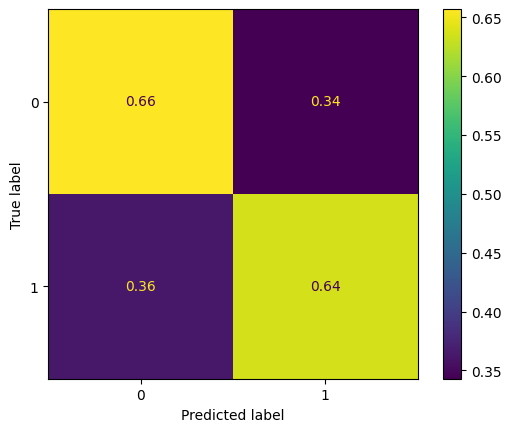

In [98]:
disp = ConfusionMatrixDisplay.from_estimator(estimator=model_pipeline_rf,
                                             X=X_test,
                                             y=y_test,
                                             normalize='true')